In [1]:
import rasterio as rio
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import dask as da
import h5py as h5
import geopandas as gpd
import pandas as pd
from spectral.io import envi
import matplotlib
import dask.array as da

# enable fiona KML
import fiona
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

# basemap
import contextily as ctx

def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [4]:
reflectance_files_april09

['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
 '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
 '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
 '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
 '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5']

In [5]:
## try to open one of the data files with xarray
data_file_VNIR = radiance_files_VNIR_april09[0]
data_file_SWIR = radiance_files_SWIR_april09[0]
data_file_NEON = reflectance_files_april09[-1] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)

NEON ID:  R10C


In [6]:
## define some functions for creating xarray datasets out of the files
def NEON_create_rad_xarr_from_h5_file(h5file, nid= 'R10C', nodata=-9999):
    
    # Read H5 file
    f = h5.File(h5file, "r")
    
    # spectral
    wavelength = f[nid]['Radiance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Radiance']['Metadata']['Spectral_Data']['FWHM'][:]
    
    # CRS
    crs_str = f[nid]['Radiance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
    crs_epsg = f[nid]['Radiance']['Metadata']['Coordinate_System']['EPSG Code'].value
    crs_mapinfo = f[nid]['Radiance']['Metadata']['Coordinate_System']['Map_Info'].value
    crs_proj4 = f[nid]['Radiance']['Metadata']['Coordinate_System']['Proj4'].value
    
    #arr = f[nid]['Radiance']['Radiance_Data'][:]
    arr = da.from_array(f[nid]['Radiance']['Radiance_Data'], chunks=(256,256,256))
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)
    
    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    return x, y, xr_cube_ma

def NEON_create_refl_xarr_from_h5_file(h5file, nid='R10C', nodata=-9999):
    
    # Read H5 file
    f = h5.File(h5file, "r")
    
    # spectral
    wavelength = f[nid]['Reflectance']['Metadata']['Spectral_Data']['Wavelength'][:]
    fwhm = f[nid]['Reflectance']['Metadata']['Spectral_Data']['FWHM'][:]
    
    # CRS
    crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
    crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'].value
    crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'].value
    crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'].value
    
    #arr = f[nid]['Reflectance']['Reflectance_Data'][:]
    arr = da.from_array(f[nid]['Reflectance']['Reflectance_Data'], chunks=(256,256,256))
    
    mapinfo_list = [a.strip() for a in str(crs_mapinfo).split(',')]
    mapinfo = [float(a) for a in mapinfo_list[1:7]]
    mapinfo
    pix_size = mapinfo[0]
    x = np.arange(mapinfo[2], mapinfo[2] + pix_size*arr.shape[1], pix_size)
    y = np.arange(mapinfo[3], mapinfo[3] - pix_size* arr.shape[0], -pix_size)
    
    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != -9999)
    
    return x, y, xr_cube_ma
    
def hw_create_xarr_from_envi_file(hwfile, nodata=-9999):

    ## read the array and transform info
    with rio.open(hwfile) as src:
        prof = src.profile
        meta = src.meta
        arr = src.read()
        
    # get the wavelengths from the ENVI header
    envi_meta = envi.open(hwfile + '.hdr').metadata
    wavelength = [float(l) for l in envi_meta['wavelength']]
    
    # get some coordinate array information
    aff = meta['transform']
    pix_size_x = aff.a
    ul_x = aff.c
    pix_size_y = aff.e
    ul_y = aff.f
    
    # move bands to back
    arr = np.rollaxis(arr, 0, 3)
    
    # create the lon / lat coordinate arrays
    x = np.arange(ul_x, ul_x + pix_size_x*arr.shape[1], pix_size_x)
    y = np.arange(ul_y, ul_y + pix_size_y* arr.shape[0], pix_size_y)
    
    # dimension check
    if x.shape[0] != arr.shape[1]:
        # do something
        xsh = x.shape[0]
        ash = arr.shape[1]
        dif = xsh - ash
        
        # xdim more entries than array columns
        if dif > 0:
            x = x[:-dif]
        
        # xdim less entries than array columns
        else:
            raise ValueError('check your affine transform. xdim entries less than array columns')
    
    if y.shape[0] != arr.shape[0]:
        # do something
        ysh = y.shape[0]
        ash = arr.shape[0]
        dif = ysh - ash
        
        # ydim more entries than array rows
        if dif > 0:
            y = y[:-dif]
        
        # ydim less entries than array rows
        else:
            raise ValueError('check your affine transform. xdim entries less than array columns')
    
    print(arr.shape)
    print(x.shape)
    print(y.shape)
    
    # create the xarray and mask out the nodata
    xr_cube = xr.DataArray(arr, {'y': y, 'x': x, 'bands': wavelength}, dims=['y', 'x', 'bands'])
    xr_cube_ma = xr_cube.where(xr_cube != nodata)
    
    return x, y, xr_cube_ma
        
        


In [7]:
## read the data into xarray datasets
# x_vnir, y_vnir, xarr_VNIR = hw_create_xarr_from_envi_file(data_file_VNIR)
# x_swir, y_swir, xarr_SWIR = hw_create_xarr_from_envi_file(data_file_SWIR)
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256,256,256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256,256,256))


In [8]:
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

# Simulate a spatial extraction

In [9]:
from shapely.geometry import Point

# cross-roads point
buffer_dist = 2 # meters
pt = Point(-105.24512887001036, 40.1302875511837)
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))
pt_df = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)

## use the shapefile
pt = gdf_4326['geometry'].values[0]
pt_label = gdf_4326['comments'].values[0]
pt_df = gpd.GeoDataFrame({'geometry' : [pt]}, crs=fiona.crs.from_epsg(4326))
pt_df = pt_df.to_crs(epsg=3857).buffer(buffer_dist, resolution=1).to_crs(epsg=4326)

# Create a raster mask with the point geometry


In [10]:
from rasterio import features
from affine import Affine

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['y'], coords['x'])
    out_shape = (len(coords['y']), len(coords['x']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('y', 'x'))

In [11]:
# create mask datasets for the VNIR and SWIR data separately
ds_vnir = xr.Dataset(coords={'y':y_vnir, 'x':x_vnir})
shapes = [(shape, n) for n, shape in enumerate(pt_df.geometry)]
ds_vnir['aoi'] = rasterize(shapes, ds_vnir.coords)
ds_vnir['aoi'] = ds_vnir.aoi + 1

ds_swir = xr.Dataset(coords={'y':y_swir, 'x':x_swir})
shapes = [(shape, n) for n, shape in enumerate(pt_df.geometry)]
ds_swir['aoi'] = rasterize(shapes, ds_swir.coords)
ds_swir['aoi'] = ds_swir.aoi + 1



In [12]:
# apply the mask to the data cube
example_vnir = ds_vnir.aoi * xarr_VNIR 
example_swir = ds_swir.aoi * xarr_SWIR


In [13]:
# get the valid y and x coordinates, then reduce to unique values
val_y, val_x = np.where(ds_vnir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_vnir = example_vnir.sel(y=y_vnir[u_y], x=x_vnir[u_x])

val_y, val_x = np.where(ds_swir.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_swir = example_swir.sel(y=y_swir[u_y], x=x_swir[u_x])


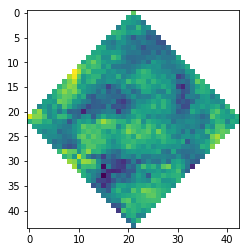

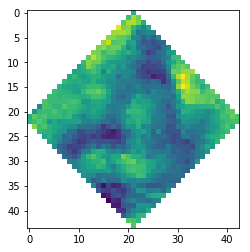

In [14]:
# plot some images
plt.imshow(ex_vnir[:,:,34])
plt.show()

plt.imshow(ex_swir[:,:,34])
plt.show()

In [15]:
# concatenate the data
print('vnir shape', ex_vnir.shape)
print('swir shape', ex_swir.shape)
full_ex = np.vstack((ex_vnir.values.reshape(-1, ex_vnir.shape[-1]).T, ex_swir.values.reshape(-1, ex_swir.shape[-1]).T))

# concatenate the wavelength vectors
# full_wav = np.concatenate((ex_vnir.coords['band'].values, ex_swir.coords['band'].values))
full_wav = np.concatenate((ex_vnir.coords['wavelength'].values, ex_swir.coords['wavelength'].values))
full_wav = np.unique(full_wav)
print('full_ex shape', full_ex.shape)

vnir shape (44, 43, 270)
swir shape (44, 43, 270)
full_ex shape (540, 1892)


In [16]:
full_wav

array([ 399.065,  401.3  ,  403.535,  405.77 ,  408.005,  410.24 ,
        412.475,  414.71 ,  416.945,  419.179,  421.414,  423.649,
        425.884,  428.119,  430.354,  432.589,  434.824,  437.059,
        439.294,  441.529,  443.764,  445.999,  448.234,  450.469,
        452.704,  454.939,  457.174,  459.409,  461.644,  463.879,
        466.113,  468.348,  470.583,  472.818,  475.053,  477.288,
        479.523,  481.758,  483.993,  486.228,  488.463,  490.698,
        492.933,  495.168,  497.403,  499.638,  501.873,  504.108,
        506.343,  508.578,  510.813,  513.048,  515.282,  517.517,
        519.752,  521.987,  524.222,  526.457,  528.692,  530.927,
        533.162,  535.397,  537.632,  539.867,  542.102,  544.337,
        546.572,  548.807,  551.042,  553.277,  555.512,  557.747,
        559.982,  562.217,  564.451,  566.686,  568.921,  571.156,
        573.391,  575.626,  577.861,  580.096,  582.331,  584.566,
        586.801,  589.036,  591.271,  593.506,  595.741,  597.

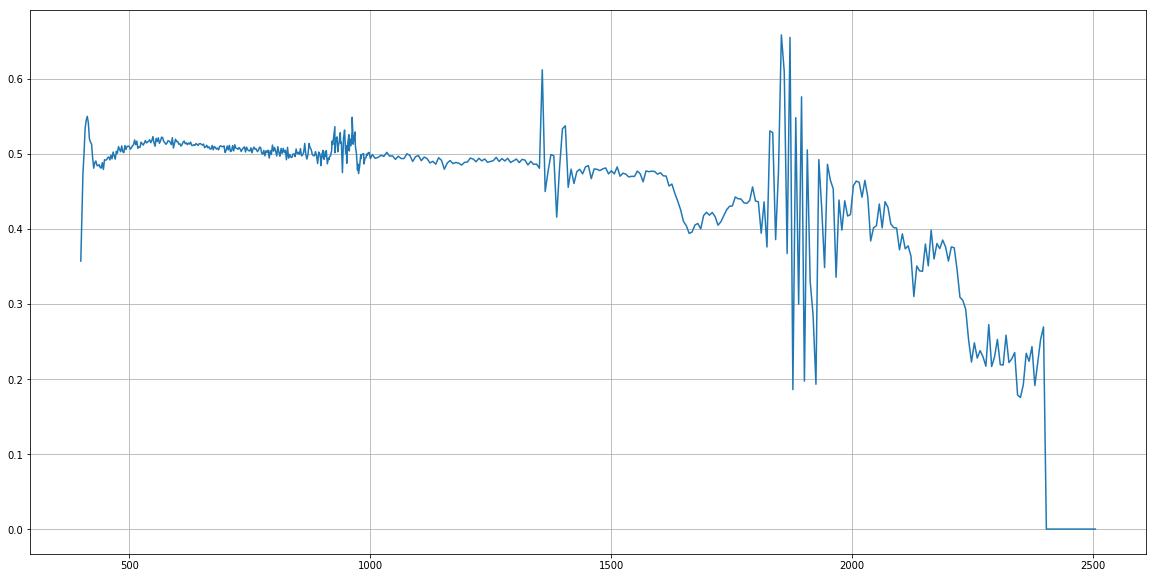

In [17]:
# plot one!
plt.figure(figsize=(20,10))
# plt.plot(full_ex.values.reshape(-1, full_ex.shape[-1]).T) # this plots all of them at unit spacing
plt.plot(full_wav, full_ex[:,410]) # this plots at spacing defined by wavelength vector
plt.grid(True)
plt.show()

In [18]:
## clean up
# del xarr_SWIR
# del xarr_VNIR

# convert the data array to a dask array with the .chunk method

In [19]:
x_neon, y_neon, xarr_NEON = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [20]:
# NEON's data is in UTM, hence to to_crs() call
ds_neon = xr.Dataset(coords={'y':y_neon, 'x':x_neon})
shapes = [(shape, n) for n, shape in enumerate(pt_df.to_crs(epsg=32613).buffer(2).geometry)]
ds_neon['aoi'] = rasterize(shapes, ds_neon.coords)
ds_neon['aoi'] = ds_neon.aoi + 1

example_neon = ds_neon.aoi * xarr_NEON

In [21]:
val_y, val_x = np.where(ds_neon.aoi==1)
u_y = np.unique(val_y)
u_x = np.unique(val_x)
ex_neon = example_neon.sel(y=y_neon[u_y], x=x_neon[u_x])

full_neon = ex_neon.values.reshape(-1, ex_neon.shape[-1]).T/10000
neon_wav = ex_neon.coords['bands'].values

#del xarr_NEON

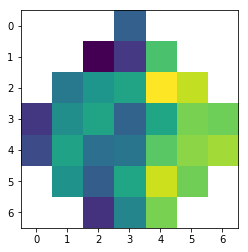

In [22]:

plt.imshow(ex_neon[:,:,34])
plt.show()

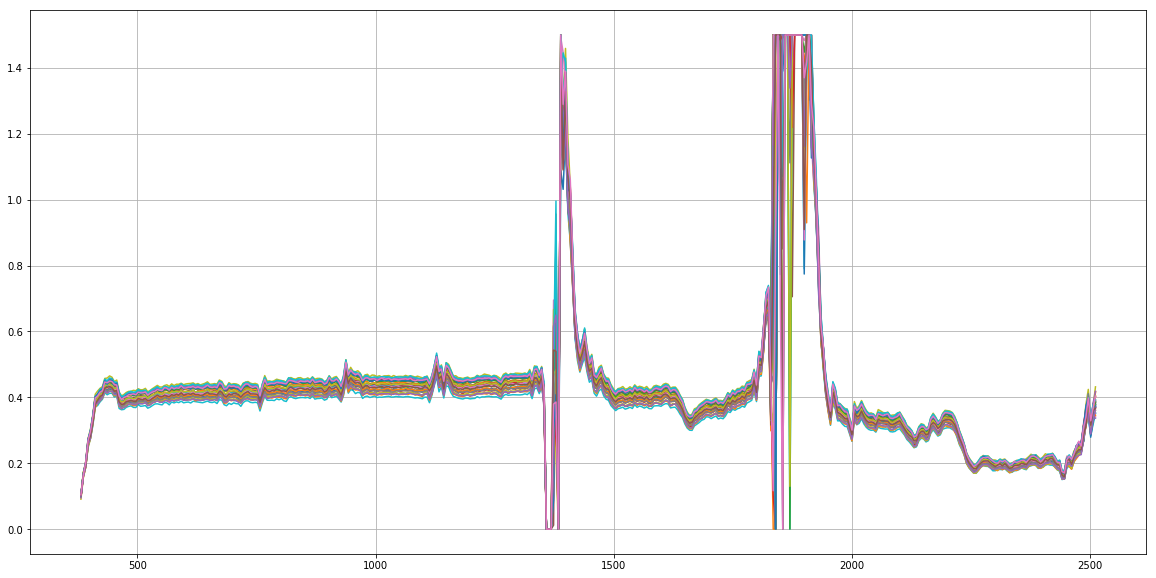

In [23]:
plt.figure(figsize=(20,10))
plt.plot(neon_wav, full_neon)
plt.grid(True)
plt.show()

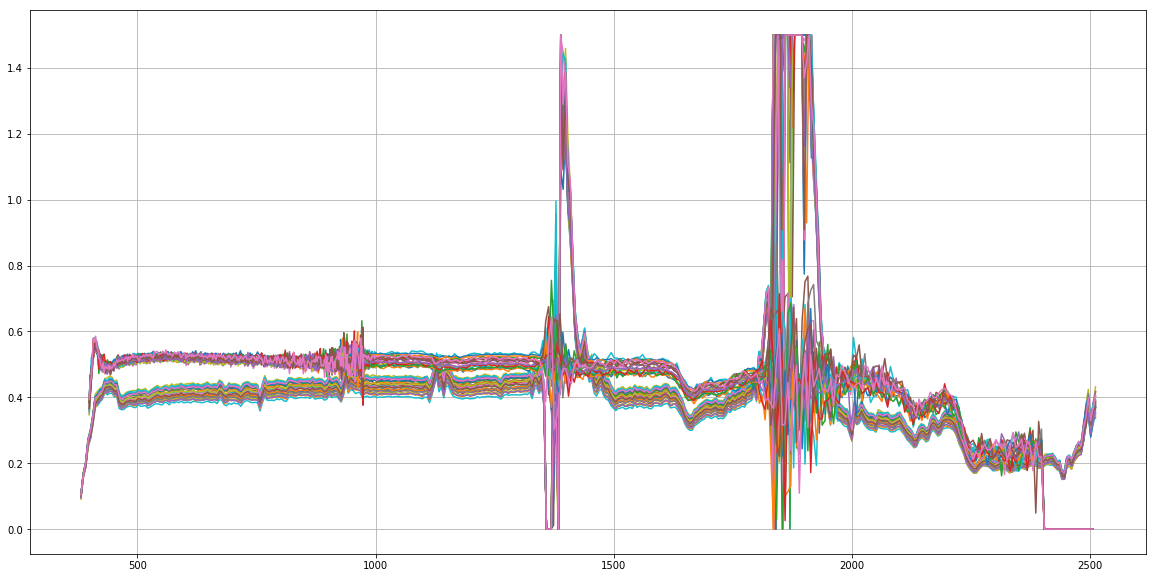

In [24]:
plt.figure(figsize=(20,10))
plt.plot(neon_wav, full_neon)
plt.plot(full_wav, full_ex[:,400:420])
plt.grid(True)
plt.show()



# plot mean of both systems

In [25]:
hw_mean = np.nanmean(full_ex, axis=1)
hw_max = np.nanmax(full_ex, axis=1)
hw_min = np.nanmin(full_ex, axis=1)

neon_mean = np.nanmean(full_neon, axis=1)
neon_max = np.nanmax(full_neon, axis=1)
neon_min = np.nanmin(full_neon, axis=1)

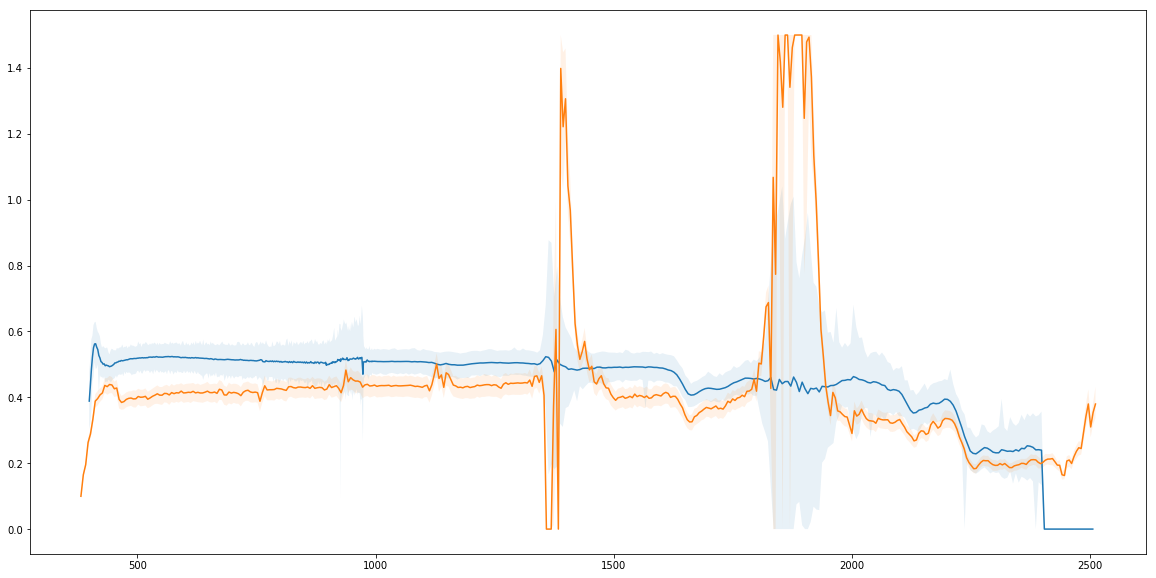

In [26]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean)
plt.fill_between(full_wav, hw_min, hw_max, alpha=0.1)
plt.plot(neon_wav, neon_mean)
plt.fill_between(neon_wav, neon_min, neon_max, alpha=0.1)
plt.show()

In [27]:
## replot masking bad bands:
# 1260 to 1560 nm (Bands 98-128)
# 1760 to 1960 nm (Bands 148-170)
bad_neon = np.where(((neon_wav > 1260) & (neon_wav < 1560)) | ((neon_wav > 1760) & (neon_wav < 1960)))
bad_hw = np.where(((full_wav > 1260) & (full_wav < 1560)) | ((full_wav > 1760) & (full_wav < 1960)))

In [28]:
hw_mean_ma = hw_mean.copy()
hw_mean_ma[bad_hw] = np.nan
hw_max_ma = hw_max.copy()
hw_max_ma[bad_hw] = np.nan
hw_min_ma = hw_min.copy()
hw_min_ma[bad_hw] = np.nan

neon_mean_ma = neon_mean.copy()
neon_mean_ma[bad_neon] = np.nan
neon_max_ma = neon_max.copy()
neon_max_ma[bad_neon] = np.nan
neon_min_ma = neon_min.copy()
neon_min_ma[bad_neon] = np.nan

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


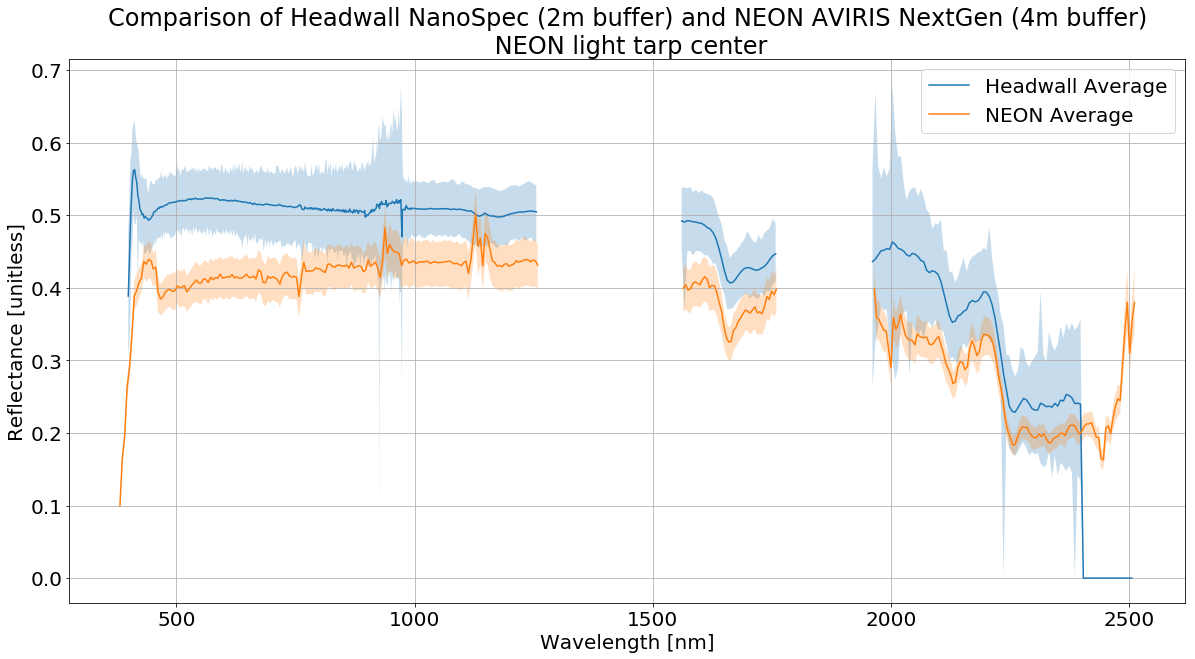

In [29]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

plt.title('Comparison of Headwall NanoSpec (2m buffer) and NEON AVIRIS NextGen (4m buffer)\n {}'.format(pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()

# load the ASD for the white tarp

In [30]:
asd_spectra1 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp1/0048WhiteTarp1_refl.spectra"
asd_spectra2 = "../CUASD/20190409_TBMT_P3C1/0048WhiteTarp2/0048WhiteTarp2_refl.spectra"
asd1 = pd.read_csv(asd_spectra1, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')
asd2 = pd.read_csv(asd_spectra2, names=['wavelength', 'refl'], header=None, delimiter=r'\t', engine='python')


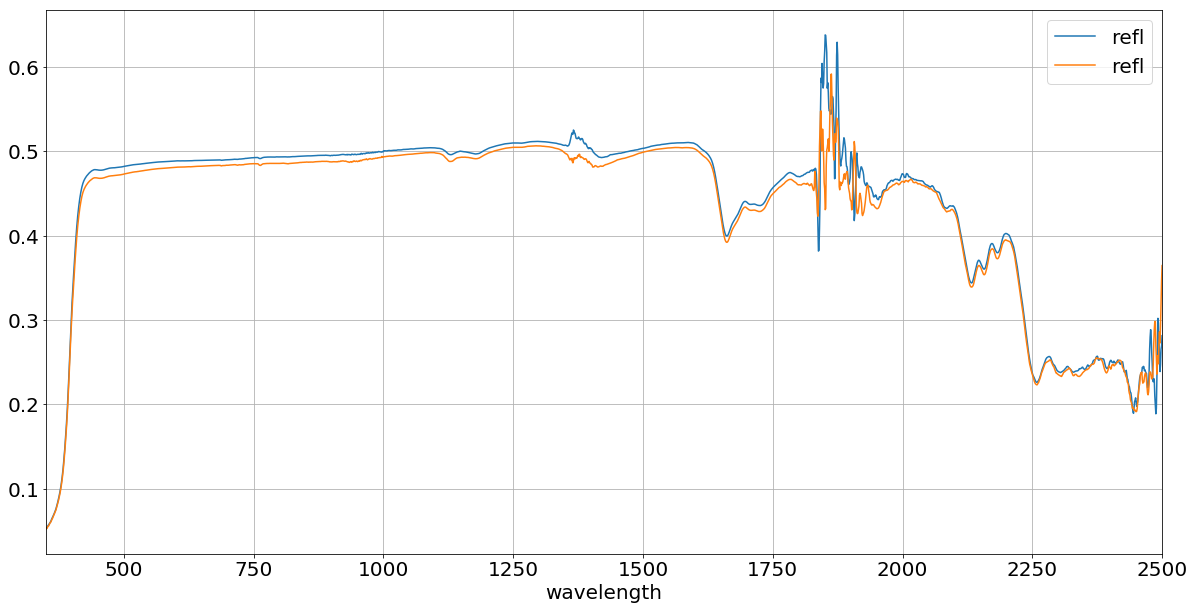

In [31]:
ax = asd1.plot(x='wavelength', y='refl', figsize=(20,10), grid=True)
asd2.plot(x='wavelength', y='refl', figsize=(20,10), grid=True, ax=ax)

# they are pretty close, so just use the first one

In [32]:
## mask the water vapor features
asd_wav = asd1.wavelength.values
asd_refl = asd1.refl.values
bad_asd = np.where(((asd_wav > 1260) & (asd_wav < 1560)) | ((asd_wav > 1760) & (asd_wav < 1960)))
asd_refl[bad_asd] = np.nan

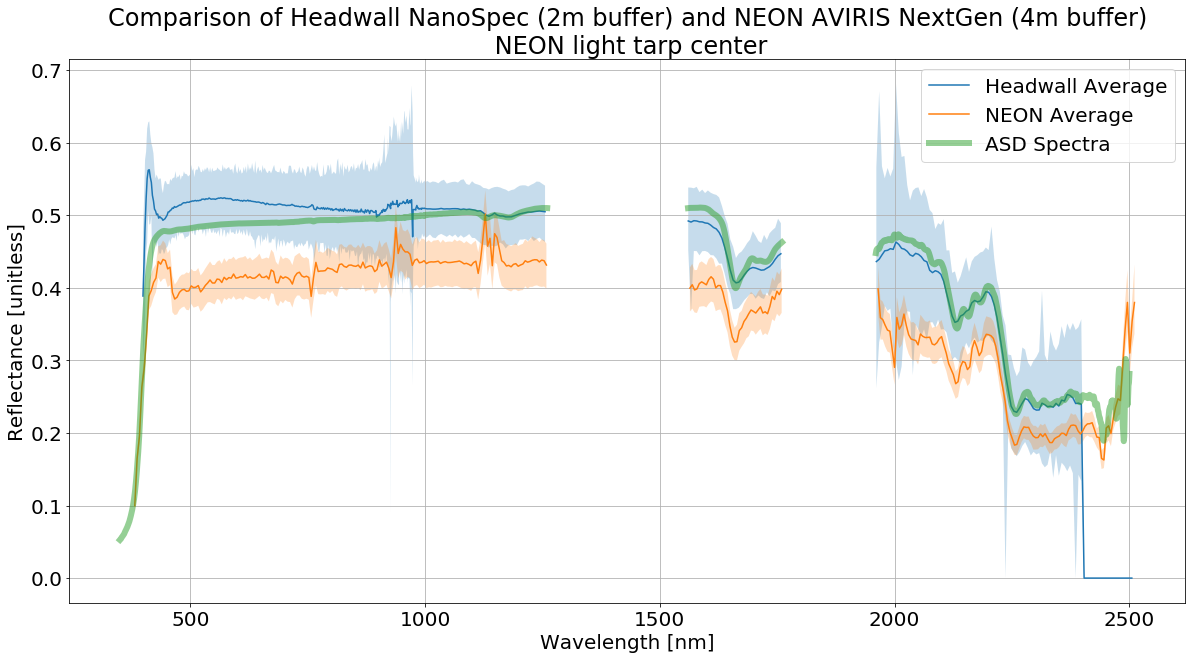

In [33]:
plt.figure(figsize=(20,10))
plt.plot(full_wav, hw_mean_ma, label='Headwall Average')
plt.fill_between(full_wav, hw_min_ma, hw_max_ma, alpha=0.25)
plt.plot(neon_wav, neon_mean_ma, label='NEON Average')
plt.fill_between(neon_wav, neon_min_ma, neon_max_ma, alpha=0.25)

# ASD spectra
plt.plot(asd_wav, asd_refl, linewidth=6, alpha=0.5, label='ASD Spectra')

plt.title('Comparison of Headwall NanoSpec (2m buffer) and NEON AVIRIS NextGen (4m buffer)\n {}'.format(pt_label))
plt.xlabel('Wavelength [nm]')
plt.ylabel('Reflectance [unitless]')
plt.grid(True)
plt.legend()
plt.show()